## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [14]:
def getW(name, shape):
    return tf.get_variable(
        name, shape,
        initializer = tf.contrib.layers.xavier_initializer()
    )


def getb(name, shape):
    return tf.get_variable(
        name, shape,
        initializer = tf.zeros_initializer
    )


def relu(X):
    return tf.nn.relu(X)


def batchNorm(id, X):
    D = X.shape[1]
    
    beta = tf.get_variable(
        "beta_" + id, shape = [D, ],
        initializer = tf.zeros_initializer
    )
    
    gamma = tf.get_variable(
        "gamma_" + id, shape = [D, ],
        initializer = tf.ones_initializer
    )
    
    mean, variance = tf.nn.moments(X, [0, ], keep_dims = False)
    
    out = tf.nn.batch_normalization(
        X,
        mean, variance,
        beta, gamma,
        1e-7
    )
    
    return out, beta, gamma
    
    

def affine(id, X, size):
    W = getW("W_" + id, [X.shape[1], size, ])
    b = getb("b_" + id, [size, ])
    
    out = tf.matmul(X, W) + b
    
    return out, W, b


def dropout(X, keepProb):
    return tf.nn.dropout(X, keepProb)


# Input size (32, 32, 3)
def myModel(X, y, is_training):
    keepProb = 1 - tf.cast(is_training, tf.float32) * 0.3
    
    XReshaped = tf.reshape(X, [-1, 32 * 32 * 3])
    
    outAffine_1, _, _ = affine("1", XReshaped, 1024)
    outBatchNorm_1, _, _ = batchNorm("1", outAffine_1)
    outRelu_1 = relu(outBatchNorm_1)
    outDropout_1 = dropout(outRelu_1, keepProb)
    
    outAffine_2, _, _ = affine("2", outDropout_1, 512)
    outBatchNorm_2, _, _ = batchNorm("2", outAffine_2)
    outRelu_2 = relu(outBatchNorm_2)
    outDropout_2 = dropout(outRelu_2, keepProb)       
    
    out, _, _ = affine("final", outDropout_2, 10)
    
    return out
    

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = myModel(X, y, is_training)

meanLoss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = y_out)
)

globalStep = tf.Variable(0, trainable = False)

learningRate = tf.train.exponential_decay(
    1e-3,
    globalStep, 700,
    0.8,
    staircase = True
)

optimizer = tf.train.AdamOptimizer(learningRate)

# Batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):
    trainStep = optimizer.minimize(meanLoss, global_step = globalStep)

Training
Iter 0 (0/766): Loss = 3.464, Accuracy = 0.03
Iter 100 (100/766): Loss = 2.094, Accuracy = 0.23
Iter 200 (200/766): Loss = 2.038, Accuracy = 0.27
Iter 300 (300/766): Loss = 1.909, Accuracy = 0.33
Iter 400 (400/766): Loss = 1.909, Accuracy = 0.39
Iter 500 (500/766): Loss = 1.842, Accuracy = 0.30
Iter 600 (600/766): Loss = 1.872, Accuracy = 0.38
Iter 700 (700/766): Loss = 1.861, Accuracy = 0.36
---
Epoch 1: Overall Loss = 1.894, Train Accuracy = 0.341, Val Accuracy = 0.472
---


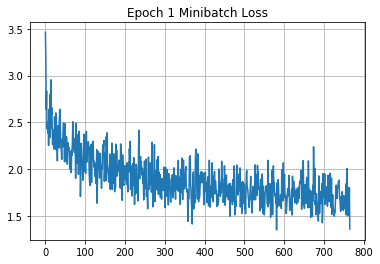

Iter 800 (34/766): Loss = 1.445, Accuracy = 0.50
Iter 900 (134/766): Loss = 1.645, Accuracy = 0.41
Iter 1000 (234/766): Loss = 1.737, Accuracy = 0.44
Iter 1100 (334/766): Loss = 1.809, Accuracy = 0.31
Iter 1200 (434/766): Loss = 1.495, Accuracy = 0.39
Iter 1300 (534/766): Loss = 1.798, Accuracy = 0.41
Iter 1400 (634/766): Loss = 1.552, Accuracy = 0.44
Iter 1500 (734/766): Loss = 1.588, Accuracy = 0.52
---
Epoch 2: Overall Loss = 1.602, Train Accuracy = 0.426, Val Accuracy = 0.509
---


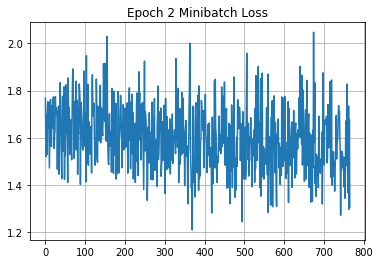

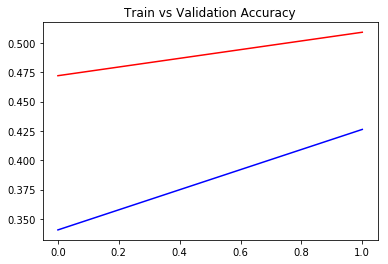

Iter 1600 (68/766): Loss = 1.667, Accuracy = 0.42
Iter 1700 (168/766): Loss = 1.426, Accuracy = 0.52
Iter 1800 (268/766): Loss = 1.744, Accuracy = 0.41
Iter 1900 (368/766): Loss = 1.291, Accuracy = 0.50
Iter 2000 (468/766): Loss = 1.665, Accuracy = 0.42
Iter 2100 (568/766): Loss = 1.544, Accuracy = 0.48
Iter 2200 (668/766): Loss = 1.359, Accuracy = 0.52
---
Epoch 3: Overall Loss = 1.510, Train Accuracy = 0.459, Val Accuracy = 0.531
---


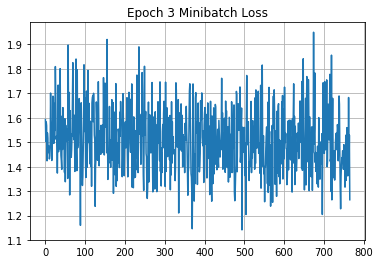

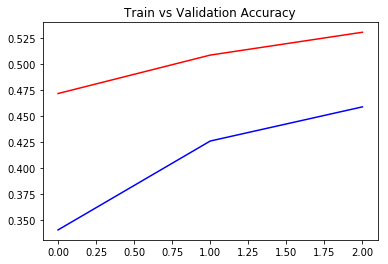

Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.514


(1.3678111524581908, 0.51400000000000001)

In [16]:
def trainMyModel(session, epochs = 1, batchSize = 64):
    trainIndicies = np.arange(X_train.shape[0])
    np.random.shuffle(trainIndicies)
    
    correctPrediction = tf.equal(tf.argmax(y_out, axis = 1), y)

    trainVariables = [meanLoss, correctPrediction, trainStep]
    
    valFeedDict = {
        X: X_val,
        y: y_val,
        is_training: False
        
    }
    
    totalCorrectHistory = []
    valCorrectHistory = []
    
    nIter = 0
    for e in range(epochs):
        totalCorrect = 0.0
        totalLoss = 0.0
        
        trainLossHistory = []        
        
        totalIteration = int(math.ceil(X_train.shape[0] / batchSize))

        for i in range(totalIteration):
            startIdx = (i * batchSize) % X_train.shape[0]
            idx = trainIndicies[startIdx: startIdx + batchSize]
            
            trainFeedDict = {
                X: X_train[idx, :],
                y: y_train[idx],
                is_training: True
            }
            
            actualBatchSize = y_train[idx].shape[0]
            
            trainLoss, trainCorr, _ = session.run(trainVariables, feed_dict = trainFeedDict)
            
            trainLossHistory.append(trainLoss)
            
            totalLoss += trainLoss * actualBatchSize
            totalCorrect += np.sum(trainCorr)
            
            if nIter % 100 == 0:
                print(
                    "Iter %d (%d/%d): Loss = %.3f, Accuracy = %.2f" % (
                        nIter, i, totalIteration,
                        trainLoss,
                        np.sum(trainCorr) / actualBatchSize
                    )
                    
                )
                
            nIter += 1
            
        totalCorrect /= X_train.shape[0]
        totalLoss /= X_train.shape[0]
        
        valCorr = session.run([correctPrediction, ], feed_dict = valFeedDict)
        valCorr = np.sum(valCorr) / y_val.shape[0]
        
        totalCorrectHistory.append(totalCorrect)
        valCorrectHistory.append(valCorr)
        
        print("---")
        
        print(
            "Epoch %d: Overall Loss = %.3f, Train Accuracy = %.3f, Val Accuracy = %.3f" % (
                  e + 1,
                  totalLoss,
                  totalCorrect,
                  valCorr
              )
            
        )
        
        print("---")
        
        plt.plot(trainLossHistory)
        plt.grid(True)
        plt.title("Epoch %d Minibatch Loss" % (e + 1, ))
        plt.show()
        
        if e > 0:
            plt.plot(totalCorrectHistory, label = "Train", color = "blue")
            plt.plot(valCorrectHistory, label = "Val", color = "red")
            plt.title("Train vs Validation Accuracy")
            plt.show()
            
    return totalLoss, totalCorrect



sess = tf.Session()

sess.run(tf.global_variables_initializer())

print("Training")
trainMyModel(sess, 3, 64)

print("Validation")
run_model(sess, y_out, meanLoss, X_val, y_val, 1, 64)

In [17]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,meanLoss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,meanLoss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 1.35 and accuracy of 0.52
Validation
Epoch 1, Overall loss = 1.37 and accuracy of 0.52


(1.3704837455749512, 0.52000000000000002)

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [18]:
print('Test')
run_model(sess,y_out,meanLoss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.4 and accuracy of 0.497


(1.4042024431228637, 0.49740000000000001)